# Fit MCE data taken on TmVO4 samples
both in DR (plate-like sample) and in He3 (needles)

In [1]:
# Standard Python libraries
import os, re, sys
from datetime import date
from importlib import reload
from warnings import warn

# Data analysis libraries
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Plotting libraries
%matplotlib
from matplotlib import pyplot as plt, rcsetup, rc, rcParams
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

Using matplotlib backend: Qt5Agg


In [2]:
for key in ['dataset', 'I', 'R', 'H', 'T', 'Tpuck', 'dH', 'sweeprates',\
            'mce_sim', 'mce_fit', 'refsweep', 'us', 'Hi', 'Ti', 'Tpucki']:
    if key not in locals():
        exec(f'{key}={{}}')

In [3]:
datFilePath = r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE'
os.chdir(datFilePath)
file_str = 'Run2_0p5uA.dat'
m = re.match('Run(\d)_(0p\d).*', file_str)
runID = int(m.group(1))
dataset[runID] = pd.read_csv(file_str, sep=', ')
I[runID] = float(m.group(2).replace('p','.'))*1e-6# input current, in amps
dataset[runID]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,Time,Temperature(K),Field(T),LockinX(V),LockinY(V),Date = 7/29/2017 9:53 PM
0,9:53 PM,0.4000,-2.041789e-07,0.002116,-0.000070,NaN
1,9:53 PM,0.4001,-2.041789e-07,0.002116,-0.000070,NaN
2,9:53 PM,0.4000,-2.041789e-07,0.002114,-0.000070,NaN
3,9:53 PM,0.4000,-2.041789e-07,0.002110,-0.000069,NaN
4,9:53 PM,0.3999,-2.041789e-07,0.002110,-0.000070,NaN
...,...,...,...,...,...,...
72122,5:55 PM,0.7004,0.000000e+00,0.001069,-0.000014,NaN
72123,5:55 PM,0.7003,0.000000e+00,0.001069,-0.000014,NaN
72124,5:55 PM,0.7001,0.000000e+00,0.001069,-0.000014,NaN
72125,5:56 PM,0.7003,0.000000e+00,0.001069,-0.000014,NaN


In [4]:
dataset[runID].columns

Index(['Time', 'Temperature(K)', 'Field(T)', 'LockinX(V)', 'LockinY(V)',
       'Date = 7/29/2017 9:53 PM'],
      dtype='object')

### Compute platform resistance
obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$

In [5]:
Hi[runID] = {'raw':dataset[runID]['Field(T)']*1e4} # Magnetic field, in Oersted
Tpucki[runID] = {'raw':dataset[runID]['Temperature(K)']}# Puck (bath) temperature, in Kelvin
R[runID] = dataset[runID]['LockinX(V)']/I[runID]# Platform resistance, in Volts

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [6]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

In [7]:
Ti[runID] = {'raw':1/betamodel(Hi[runID]['raw'], R[runID])}

In [8]:
xlabel_mce = '$H$ (Oe)'
ylabel_mce = '$T + \Delta T_\mathrm{MCE}$ (K)'

Text(0.5, 1.0, 'Raw MCE traces run 2')

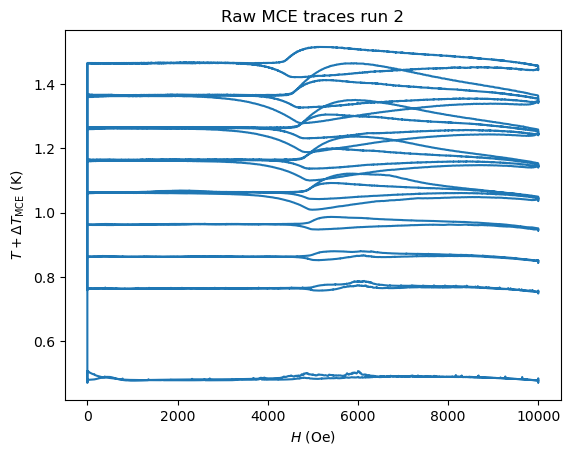

In [9]:
# Raw MCE traces
runID = 2
%matplotlib inline
fig = plt.figure()
plt.plot(Hi[runID]['raw'], Ti[runID]['raw'])
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.title(f'Raw MCE traces run {runID}')

In [10]:
for idx in [2]:
    for el in [Hi, Ti]:
        el[idx]['smoothed'] = gaussian_filter1d(el[idx]['raw'], 10)

Text(0.5, 1.0, 'Smoothed MCE traces run 2')

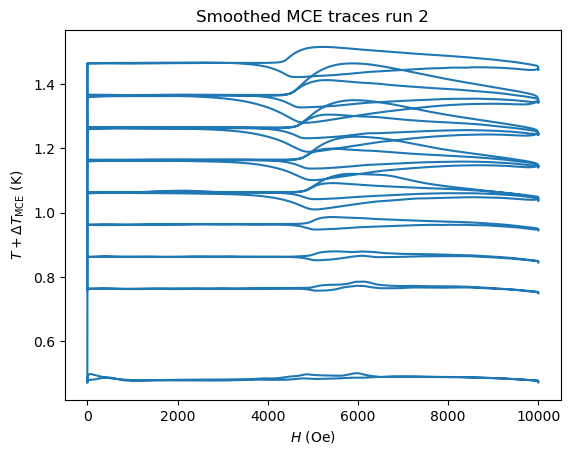

In [11]:
# Smoothed MCE traces
fig = plt.figure()
plt.plot(Hi[runID]['smoothed'], Ti[runID]['smoothed'])
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.title(f'Smoothed MCE traces run {runID}')

In [12]:
dH[runID] = pd.Series(np.diff(Hi[runID]['smoothed']))
dH[runID].head

<bound method NDFrame.head of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
72121    0.0
72122    0.0
72123    0.0
72124    0.0
72125    0.0
Length: 72126, dtype: float64>

In [13]:
# Extract sweeprates from dH data
for i in [2]:
    udh, cdh = np.unique(np.round(dH[2]), return_counts=True)
    sweeprates[i] = udh[np.logical_and(cdh>1e3, udh!=0)]
    us[i], cs = np.unique(abs(sweeprates[2]), return_counts=True)
    if 4<=len(sweeprates[i])<=5:
        refsweep[i] = np.mean(us[i][cs==2])# take the mean of sweeprates used for both up- and downsweeps
    elif len(sweeprates[i])>=6:
        warn(f"Run #{i} has more than 3 absolute sweeprates,\
 it is recommended looking into this manually.")

In [14]:
# Separate traces based on sweeprate
for pq in [(Hi, H), (Ti, T), (Tpucki, Tpuck)]:# pq stands for physical quantity
    for idx in [2]:
        # Initialize dictionaries to store data
        if idx not in pq[0].keys():
            pq[0][idx] = {}
        if 'dict' not in pq[0][idx].keys():
            pq[0][idx]['dict'] = {}
            
        # Reduce length of reference arrays by 1, since dH has 1 element less than these
        try:
            Xm = np.mean([pq[0][idx]['smoothed'][:-1], pq[0][idx]['smoothed'][1:]], 0)
        except KeyError:
            Xm = np.mean([pq[0][idx]['raw'][:-1], pq[0][idx]['raw'][1:]], 0)
        
        # Seperate datasets based on sweeprate
        for ir, sr in enumerate(sweeprates[idx]):
            if ir==0:
                refsweep = np.mean([sr, sweeprates[idx][ir+1]])
                pq[0][idx]['dict'][sr] = pd.Series(Xm[dH[idx]<refsweep])
            elif ir<len(sweeprates[idx])-1:
                rsm = np.mean([sr, sweeprates[idx][ir-1]])
                rsp = np.mean([sr, sweeprates[idx][ir+1]])
                pq[0][idx]['dict'][sr] = pd.Series(Xm[np.logical_and(dH[idx]<rsp, dH[idx]>rsm)])
            else:
                refsweep = np.mean([sr, sweeprates[idx][ir-1]])
                pq[0][idx]['dict'][sr] = pd.Series(Xm[dH[idx]>refsweep])
#         pq[0][idx]['dict']['slow up'] = pd.Series(Xm[np.logical_and(dH[idx]<refsweep, dH[idx]>0)])
        pq[1][idx] = pd.concat(pq[0][idx]['dict'], axis=1)# 0 was chosen as key for simplicity

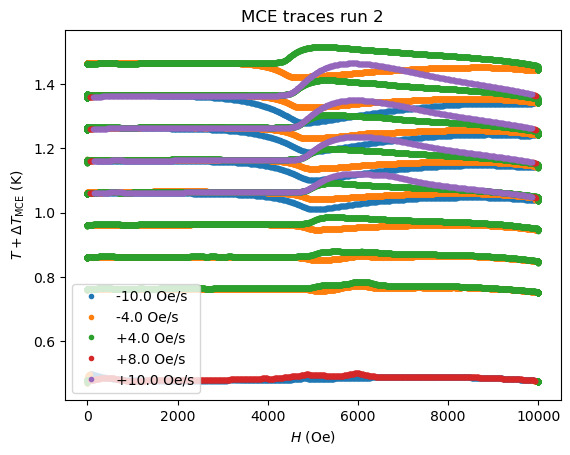

In [15]:
# import ipywidgets as widgets
%matplotlib inline
runID = 2
fig = plt.figure()
for i, s in enumerate(H[runID].columns):
    plt.plot(H[runID][s], T[runID][s], '.', label=f'{sweeprates[runID][i]:+.1f} Oe/s')
plt.title(f'MCE traces run {runID}')
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.legend()

In [16]:
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
import MCE_simulations.mce_no_demag as mce
# mce = reload(mce)# if mce is changed

In [17]:
# Identify values of bath temperature used for the measurements

# ut, ct = np.unique(np.round(Tpucki[runID]['raw'], 2), return_counts=True)# Use raw data
ut, ct = np.unique(np.round(Tpuck[runID], 1), return_counts=True)# Same

# Show counts for each value of bath temperature, ignoring NaN
print([[ut[ut>0][i], ct[ut>0][i]] for i in range(len(ut[ut>0]))])
utbath = ut[ct>1000]# select only those values that occur in more than 1000 data points
utbath#

[[0.4, 2537], [0.7, 5231], [0.8, 5230], [0.9, 5223], [1.0, 7465], [1.1, 7466], [1.2, 7463], [1.3, 7465], [1.4, 5230]]


array([0.4, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])

In [194]:
##### import ipywidgets as widgets
%matplotlib 
runID = 2
if runID not in mce_fit.keys():
    mce_fit[runID] = {}

fig = plt.figure()
for idx, sr in enumerate(sweeprates[runID][:]):#sweeprates[2][abs(sweeprates[2])==us[2][0]]:
    # select data to analyze; note: solve_ivp fails for H<1 Oe (H/Hc0<2e-3)
    dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
                                np.round(Tpuck[runID][sr], 1)==1.)
    Hf = H[runID][sr][dataFilter]
    Tf = T[runID][sr][dataFilter]
    Tbath = np.mean(Tf[Hf<1e3])
    prms = mce.mce_parameters(sweeprate=sr, Tbath=Tbath)
    Hc0 = prms['Hc0'].value
    Tc0 = prms['Tc0'].value
    if sr>0:
        trace_str = 'upsweep'
    else:
        trace_str = 'downsweep'
#     mce_sim[s] = pd.DataFrame(mce.mce_residual(prms, Hf, data=Tf, trace=trace_str))

    Hffit = np.logical_and(Hf>4e3, Hf<7e3)
    if len(Hffit)<100: continue
    out = minimize(mce.mce_residual, prms, args=(Hf[Hffit],),\
                   kws={'data':Tf[Hffit], 'trace':trace_str}, max_nfev=150)
    mce_fit[runID][sr] = out
# #     out = minimize(mce.mce_residual, prms, args=(Hf,))
    mce_sim[sr] = mce.mce_residual(out.params, Hf, data=None, trace=trace_str)
    srlabel = f'{sr:+.0f} Oe/s'
    plt.plot(Hf, Tf, '.', color=f'C{idx}', label=f'data {srlabel}')
#     plt.plot(Hf, mce_sim[sr], '-', color=f'C{idx}', label=f'fit {sr:+.1f} Oe/s')
    # Plotting the fit with sorted arguments avoids lines connecting low and high Hf values
    plt.plot(Hf.sort_values(), mce_sim[sr][Hf.argsort()], '-', 
             color=f'C{idx}', label=f'fit {srlabel}')
plt.title(f'MCE traces run {runID}')
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.legend()

Using matplotlib backend: Qt5Agg


In [19]:
# Check counts for a given sweeprate
# u,c = np.unique(np.round(Tpuck[runID][sr][~np.isnan(Tpuck[runID][sr])],1), return_counts=True)
u,c = np.unique(np.round(Tpuck[runID][sr], 1), return_counts=True)
print([[u[u>0][i], c[u>0][i]] for i in range(len(u[u>0]))])
u[u>0]

[[0.4, 88], [0.7, 2572], [0.8, 2581], [0.9, 2575], [1.0, 2684], [1.1, 2671], [1.2, 2696], [1.3, 2660], [1.4, 2578]]


array([0.4, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])